In [6]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.18.0
Num GPUs Available: 0


In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [8]:
# Set dataset paths
train_dir = "dataset\TRAIN"  # Replace with your training dataset path
test_dir = "dataset\TEST"    # Replace with your test dataset path

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation/test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Class indices
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)


Found 1486 images belonging to 2 classes.
Found 408 images belonging to 2 classes.
Class labels: ['Caries', 'Gingivitis']


In [9]:
# Load a pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Train the model
EPOCHS = 50

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=test_generator.samples // BATCH_SIZE
)

# Save the model
model.save("oral_disease_classifier.h5")


c:\Users\anike\.conda\envs\tensor\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5590 - loss: 0.9648 - val_accuracy: 0.5964 - val_loss: 0.6655
Epoch 2/50
 1/46 ━━━━━━━━━━━━━━━━━━━━ 38s 862ms/step - accuracy: 0.7188 - loss: 0.5543

c:\Users\anike\.conda\envs\tensor\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.7188 - loss: 0.5543 - val_accuracy: 0.5833 - val_loss: 0.6718
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7002 - loss: 0.5956 - val_accuracy: 0.6901 - val_loss: 0.5956
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.8750 - loss: 0.2525 - val_accuracy: 0.6927 - val_loss: 0.6047
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6968 - loss: 0.5974 - val_accuracy: 0.6875 - val_loss: 0.6066
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.5312 - loss: 0.7653 - val_accuracy: 0.6927 - val_loss: 0.5886
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6846 - loss: 0.5882 - val_accuracy: 0.5339 - val_loss: 0.6469
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.8438 - loss: 0.4946 - val_accuracy: 0.4948 - val_loss: 0.6665
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13591s 302s/step - accuracy: 0.5696 - loss: 0.6751 - val_accuracy: 0.6953 - val

In [10]:
from tensorflow.keras.models import load_model

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 
Classification Report:
              precision    recall  f1-score   support

      Caries       0.50      1.00      0.67       204
  Gingivitis       0.00      0.00      0.00       204

    accuracy                           0.50       408
   macro avg       0.25      0.50      0.33       408
weighted avg       0.25      0.50      0.33       408



C:\Users\anike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

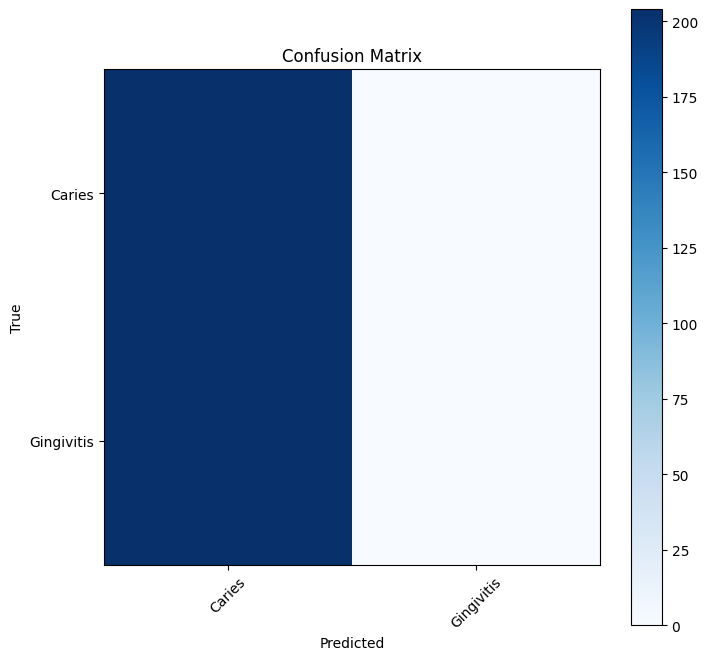

In [11]:

# Get predictions
predictions = model.predict(test_generator, verbose=1)

# Convert predictions to class indices
y_pred = np.argmax(predictions, axis=1)  # Predicted class indices
y_true = test_generator.classes           # True class indices

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Create and Display Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.yticks(range(len(class_labels)), class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
